Один из трех блоков ниже выбирается для исследования экситонных волновых функций в одном из потенциалов с известными калибровочными положениями экситонных пиков поглощения в спектре. В блоках заданы параметры потенциала Кронига-Пенни $a,b,V_0$:

\begin{equation}
V_{KP}(x) =
\begin{cases}
   0 & \text{0 < x < a}\\
   V_0 & \text{-b < x < 0},
\end{cases}
\end{equation}

величины разбиения первой зоны Бриллюэна и элементарной ячейки $N, N_r$, а также параметры в ядрах и формуле построения оптического спектра

In [1]:
a = 3.             #width of a well
b = 3.             #width of a barrier
V = 1.0             #height of a barrier
N = 451               #fragmentation of Brillouin zone from 0 to pi/(a+b)
N_r = 81                   #fragmentation of lattice (for counting integrals in F)
A_SC = 0.955*0.907                #parameter in SC kernel
alph = 0.01                #another parameter in SC
A_cont = 3.77*0.895             #parameter in contact kernel
A_LR = 6.2               #parameter in long-range kernel
q = 0.024                #small but finite parameter in exp for spectra counting
eta = 0.0035            #blur of spectra peaks
fr_end = 0.4            #maximum frequency in spectra graph

In [7]:
a = 0.5
b = 0.5 
V = 20.0  
N = 451 
N_r = 80 
A_SC = 2.39*4.3
alph = 0.01 
A_cont = 10.7   
A_LR = 19.55
q = 0.7
eta = 0.08
fr_end = 5.

In [13]:
a = 2.6 
b = 0.4 
V = 8.0  
N = 451 
N_r = 90
A_SC = 0.898*1.386
alph = 0.01
A_cont = 3.7*0.95
A_LR = 5.955
q = 0.03
eta = 0.009
fr_end = 2.

In [14]:
import numpy
from scipy.misc import derivative
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import scipy.special as spec
from scipy.integrate import simps
from scipy.integrate import trapz
import cmath
Volume = numpy.sqrt(N)*(a+b)
E_k = lambda E: (cmath.cos(cmath.sqrt(2*E)*a) * cmath.cosh(b * cmath.sqrt(2 * V - 2 * E)) + \
                   (V / (2*E) - 1.) / cmath.sqrt(V/E - 1.) * cmath.sinh(cmath.sqrt(2*V - 2*E)*b) * \
                    cmath.sin(cmath.sqrt(2*E)*a) - cmath.cos(k * (a+b))).real
k_map = numpy.linspace(-numpy.pi/(a+b),numpy.pi/(a+b),N)
r_map = numpy.linspace(-b,a,N_r)
for i in range (0, N_r):
    if (r_map[i]<=0):
        N_0 = i
h = r_map[1] - r_map[0]

Блок построения зонной структуры - аналогичен таковому в программе TDDFT_for_excitons.

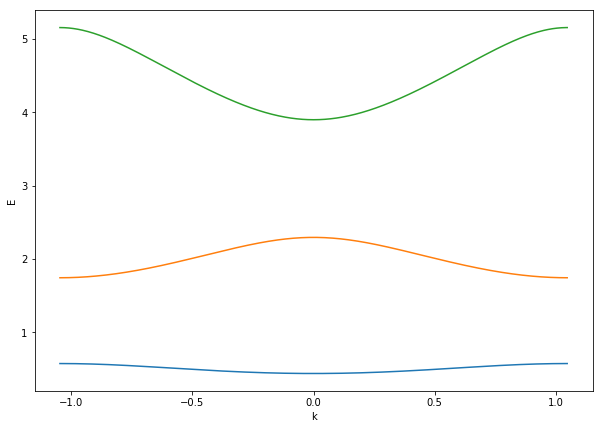

Band gap is
1.6039904923229877


In [15]:
plt.rcParams['figure.figsize'] = [10,7]
Func = lambda E: cmath.cos(cmath.sqrt(2*E)*a) * cmath.cosh(b * cmath.sqrt(2 * V - 2 * E)) + \
                   (V / (2*E) - 1.) / cmath.sqrt(V/E - 1.) * cmath.sinh(cmath.sqrt(2*V - 2*E)*b) * \
                    cmath.sin(cmath.sqrt(2*E)*a)
E_border = numpy.zeros(6)
E_map = numpy.zeros((N,3))
e = 0.; zone = 0; checker = False
while zone < 3:
    e = e + V/1000.
    if abs(Func(e))<=1 and checker == False:
        E_border[2*zone] = e
        checker = True
    if abs(Func(e))>1 and checker == True:
        E_border[2*zone+1] = e - V/1000.
        checker = False
        zone = zone + 1
fig,ax = plt.subplots()
for zone in range (0,3):
    for i in range (0,N):
        k = k_map[i]
        l = opt.fsolve(E_k, (E_border[2*zone+1] + E_border[2*zone])/2.)
        E_map[i,zone] = l[0]
    ax.plot(k_map, E_map[:,zone])
plt.xlabel('k'); plt.ylabel('E')
plt.rcParams.update({'font.size': 18})
plt.show()

print("Band gap is")
print(E_map[N//2,2] - E_map[N//2,1])

Блок расчета дискретизированных значений волновых функций по разбиению по элементарной ячейке решетки - аналогичен таковому в программе TDDFT_for_excitons.

In [16]:
#alternatively counts fi(x) for intermideate coordinates
fi = numpy.zeros((N_r,N,2),dtype = complex)
fi_alt = numpy.zeros((N_r-1,N,2),dtype = complex)
opt = numpy.zeros((N,4),dtype = complex)
r_map_alt = r_map[:-1] + h/2.
for i in range (0, N_r-1):
    if (r_map[i]<=0.):
        N_0_alt = i
X_full = [[],[]]
for zone in range (0,2):
    opt[:,zone] = numpy.sqrt(2.*E_map[:,zone+1])
    opt[:,zone+2] = numpy.sqrt(2.*(E_map[:,zone+1] - V), dtype=complex)
for z in range (0,2):
    for i in range (0,N):
        k = k_map[i]
        A = numpy.array([[1.,1.,-1.],[-opt[i,z],opt[i,z],opt[i,z+2]],[cmath.exp(-1.j*k*(a+b)-1.j*a*opt[i,z]),\
                            cmath.exp(-1.j*k*(a+b)+1.j*a*opt[i,z]),-cmath.exp(1.j*opt[i,z+2]*b)]],dtype=complex)
        B = numpy.array([1.,opt[i,z+2],cmath.exp(-1.j*opt[i,z+2]*b)],dtype=complex)
        X=numpy.linalg.solve(A,B)
        X = numpy.append(X[:], [1.])
        X_full[z].append(X)
X_full = numpy.array(X_full)
for z in range (0,2):
    for x in range (0,N_0):
        fi[x,:,z] = X_full[z,:,2]*numpy.exp(-1.j*opt[:,z+2]*r_map[x],dtype=complex)+\
            X_full[z,:,3]*numpy.exp(1.j*opt[:,z+2]*r_map[x],dtype=complex)
    for x in range (0,N_0_alt):
        fi_alt[x,:,z] = X_full[z,:,2]*numpy.exp(-1.j*opt[:,z+2]*r_map_alt[x],dtype=complex)+\
            X_full[z,:,3]*numpy.exp(1.j*opt[:,z+2]*r_map_alt[x],dtype=complex)
    for x in range (N_0,N_r):
        fi[x,:,z] = X_full[z,:,0]*numpy.exp(-1.j*opt[:,z]*r_map[x],dtype=complex)+\
            X_full[z,:,1]*numpy.exp(1.j*opt[:,z]*r_map[x],dtype=complex)
    for x in range (N_0_alt,N_r-1):
        fi_alt[x,:,z] = X_full[z,:,0]*numpy.exp(-1.j*opt[:,z]*r_map_alt[x],dtype=complex)+\
            X_full[z,:,1]*numpy.exp(1.j*opt[:,z]*r_map_alt[x],dtype=complex)
    for i in range (0,N):
        norm = simps(abs(fi[:,i,z])**2,x=None,dx=h)
        fi[:,i,z] = fi[:,i,z] * cmath.sqrt((a+b)/norm)
        norm = simps(abs(fi_alt[:,i,z])**2,x=None,dx=h)
        fi_alt[:,i,z] = fi_alt[:,i,z] * cmath.sqrt((a+b)/norm)

Этот блок считает $F^{vcvc}$ и полученные из него с помощью метода numpy.linalg.eigh собственные энергии вертикальных переходов системы и соответствующие им матричные элементы плотности.

Также строится гибридное ядро в рамках теории гибридного функционала. В рамках нашей минималистичной модели воспользуемся этим подходом для рассмотренных выше простых ядер, а именно, решим линейную задачу Ванье для обменно-корреляционного ядра:

\begin{equation}
    f_{xc}^{hybrid} = \alpha f^{SC}_{xc} + \beta f^{LR}_{xc} + \gamma f^{cont}_{xc},
\end{equation}
где вещественные числа $0 < \alpha, \beta, \gamma <1$. Будем подбирать такие константы $\alpha, \beta, \gamma$, чтобы получить положения экситонных пиков как на калибровочном спектре, соответствующем потенциалу I ($a=2.6, b=0.4, V=1, \omega_1 = 0.071, \omega_2 = 0.157$). Рассматривались различные дискретные величины этих параметров с шагом в 0.01 (при таком шаге энергия экситонов меняется менее чем на 0.001).

In [17]:
name = []
method = 4
F = numpy.zeros((method,N,N), dtype = complex)
name.append('Soft-Coulomb')
def R_func(x,r): return A_SC * ((r_map[x]-r_map[r])**2+alph)**(-0.5)
R_SC = numpy.fromfunction(R_func, (N_r,N_r), dtype = int)
def f_func(x,j): return simps(-fi[:,j,0]*fi[:,j,1].conj()*R_SC[:,x],x=None,dx=h,axis=0)
f_SC = numpy.fromfunction(f_func, (N_r,N), dtype = int)
def F_func(i,j): return simps(f_SC[:,j]*fi[:,i,0].conj()*fi[:,i,1],x=None,dx=h,axis=0)*2/Volume**2
F[0] = numpy.fromfunction(F_func,(N,N), dtype = int)

name.append('Long-range')
def R_func(x,r): return A_LR / (4 * numpy.pi * abs(r_map[x]-r_map_alt[r]))
R_SC = numpy.fromfunction(R_func, (N_r,N_r-1), dtype = int)
def f_func(x,j): return simps(-fi[:,j,0]*fi[:,j,1].conj()*R_SC[:,x],x=None,dx=h,axis=0)
f_SC = numpy.fromfunction(f_func, (N_r-1,N), dtype = int)
def F_func(i,j): return simps(f_SC[:,j]*fi_alt[:,i,0].conj()*fi_alt[:,i,1],x=None,dx=h,axis=0)*2/Volume**2
F[1] = numpy.fromfunction(F_func,(N,N), dtype = int)

name.append('Contact')
def f_cont(i,j): return simps(-fi[:,j,0]*fi[:,j,1].conj()*A_cont*fi[:,i,0].conj()*fi[:,i,1],x=None,dx=h,axis=0)*2/Volume**2 
F[2] = numpy.fromfunction(f_cont,(N,N), dtype = int)

"""
A = 0.05
n_x = numpy.zeros((N_r,N,N))
f_c = numpy.zeros((N_r,N,N))
for x in range (0,N_r):
    n_x[x] = ((fi[x,:,0]).dot(fi[x,:,0].conj())).real/N
name.append('ALDA_x')

a_c = (numpy.log(2) - 1.) /2. /(numpy.pi)**2
b_c = 20.4562557
p_c = (4.*numpy.pi/3.)**(1./3.)
def v_xc(n):
    return  a_c*numpy.log(1.+b_c*p_c*n**(1./3.) + b_c*p_c**2*n**(2./3.)) + n*a_c*(b_c*p_c/3./n**(2./3.)+2.*b_c*p_c**2/3./n**(1./3.))/\
        (1+b_c*p_c*n**(1./3.)+b_c*p_c**2*n**(2./3.))
for x in range(0, N_r):
    f_c[x] = derivative(v_xc, n_x[x,0,0], dx = 10**(-6) )

def f_lda_x(i,j): return simps(-fi[:,j,0]*fi[:,j,1].conj()*A*spec.kn(2,n_x[:]*numpy.pi* 0.1)*fi[:,i,0].conj()*fi[:,i,1],x=None,dx=h,axis=0)*2/Volume**2 
def f_lda_c(i,j): return simps(-fi[:,j,0]*fi[:,j,1].conj()*f_c*fi[:,i,0].conj()*fi[:,i,1],x=None,dx=h,axis=0)*2/Volume**2 
F[3] = numpy.fromfunction(f_lda_x,(N,N), dtype = int) + numpy.fromfunction(f_lda_c,(N,N), dtype = int)
"""
if (method >3):
    name.append('Hybrid')
    F[3] = F[0]*0.2 + F[1]*0.19 + F[2]*0.61

fr = numpy.zeros((method, N), dtype = complex); v = numpy.zeros((method,N,N),dtype = complex)
for i in range(0, method):
    F[i] = F[i] + numpy.diag(E_map[:,2] - E_map[:,1])
    fr[i],v[i] = numpy.linalg.eigh(F[i])

Вывод графиков зависимости квадрата плотности состояния $|\rho^{cv}(k)|^2$, которому соответсвует частота перехода $
$\omega$, от волнового числа первой зоны Бриллюэна для переходов, которые порождают экситоны, с указанием частотного положения экситона:

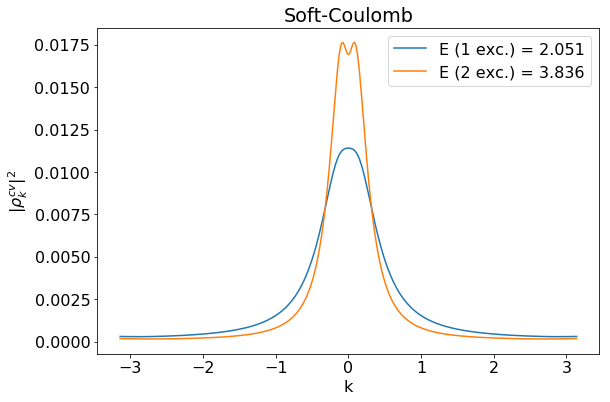

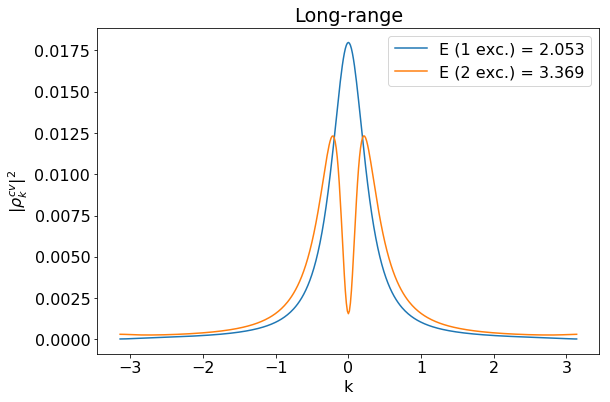

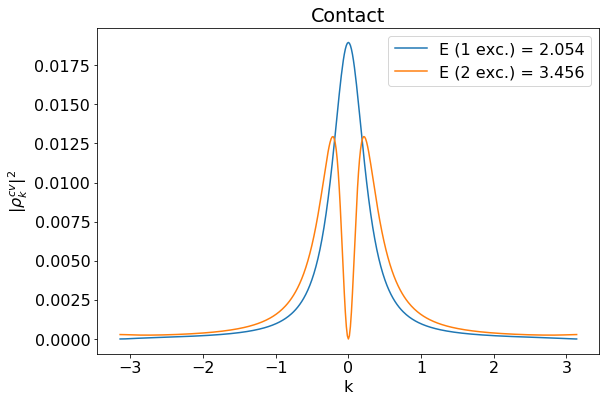

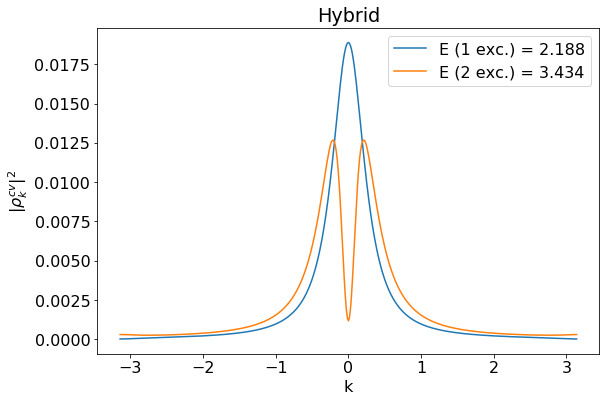

In [8]:
plt.rcParams['figure.figsize'] = [9,6]
for i in range (0,method):
    fig, ax = plt.subplots()
    num = 0
    while (fr[i,num].real < E_map[N//2,2] - E_map[N//2,1]):
        ax.plot(k_map, abs(v[i,:,num])**2, label='E (%(numero)i exc.) = %(frec)r' % {"frec": round(fr[i,num].real,3), "numero": num+1})
        num = num + 1
    ax.legend()
    plt.title(name[i])
    plt.xlabel('k'); plt.ylabel(r'$|\rho^{cv}_k|^2$')
plt.rcParams.update({'font.size': 16})
plt.xlabel('k'); plt.ylabel(r'$|\rho^{cv}_k|^2$')
plt.show()

Вывод графика зависимости квадрата плотности состояния $|\rho^{cv}(k)|^2$, которому соответствует частота перехода $
$\omega$, от волнового числа первой зоны Бриллюэна для неэкситонных одночастичных переходов:

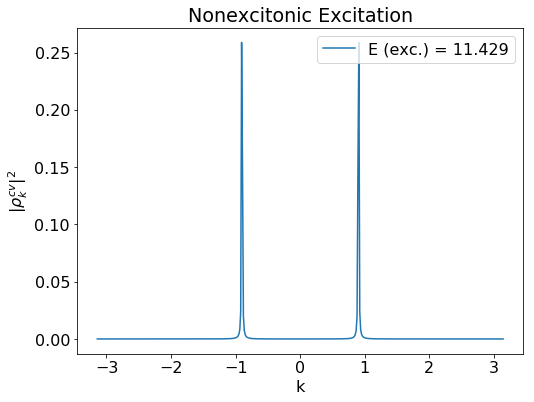

In [252]:
plt.rcParams['figure.figsize'] = [8,6]
for i in range (0,1):
    fig, ax = plt.subplots()
    num = (2*N)//7+1
    ax.plot(k_map, abs(v[i,:,num])**2, label='E (exc.) = %(frec)r' % {"frec": round(fr[i,num].real,3), "numero": num+1})
    ax.legend()
    plt.title('Nonexcitonic Excitation')
    plt.xlabel('k'); plt.ylabel(r'$|\rho^{cv}_k|^2$')
plt.rcParams.update({'font.size': 16})
plt.xlabel('k'); plt.ylabel(r'$|\rho^{cv}_k|^2$')
ax.legend(loc = 'upper right')
plt.show()

Ниже приводится зависимость энергии связи экситонов от используемой в обменно-корреляционном ядре величины подстроечного параметра. Энергия связи экситона вычисляется по формуле:

$E_{bind} = E_{gap} - \omega_{exciton}$

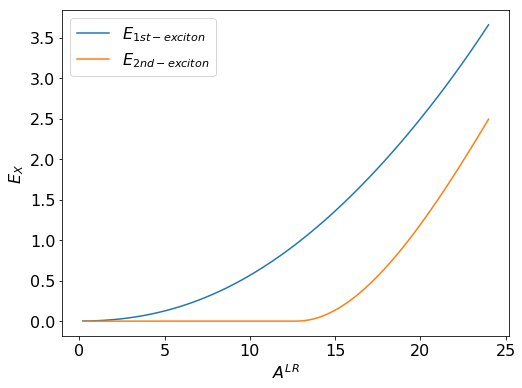

In [9]:
#to build dependence of exciton binding energy from const in kernel
bind1 = []
bind2 = []
kern = []

A_LR = 0.
for i in range (0,120):
    A_LR = A_LR + 0.2
    def R_func(x,r): return A_LR / (4 * numpy.pi * abs(r_map[x]-r_map_alt[r]))
    R_SC = numpy.fromfunction(R_func, (N_r,N_r-1), dtype = int)
    def f_func(x,j): return simps(-fi[:,j,0]*fi[:,j,1].conj()*R_SC[:,x],x=None,dx=h,axis=0)
    f_SC = numpy.fromfunction(f_func, (N_r-1,N), dtype = int)
    def F_func(i,j): return simps(f_SC[:,j]*fi_alt[:,i,0].conj()*fi_alt[:,i,1],x=None,dx=h,axis=0)*2/Volume**2
    F[1] = numpy.fromfunction(F_func,(N,N), dtype = int)
    F[1] = F[1] + numpy.diag(E_map[:,2] - E_map[:,1])
    fr[1],v[1] = numpy.linalg.eigh(F[1])
    kern.append(A_LR)
    bind1.append(E_map[N//2,2] - E_map[N//2,1] - fr[1,0].real)
    bind2.append(E_map[N//2,2] - E_map[N//2,1] - fr[1,1].real)

plt.rcParams['figure.figsize'] = [8,6]
fig, ax = plt.subplots()
ax.plot(kern, bind1, label=r'$E_{1st-exciton}$')
ax.plot(kern, bind2, label=r'$E_{2nd-exciton}$')
plt.xlabel(r'$A^{LR}$'); plt.ylabel(r'$E_X$')
plt.rcParams.update({'font.size': 16})
ax.legend(loc = 'upper left')
plt.show()